# Specific Test VI. Image Super-resolution
The following notebook is my solution for Specific Test 6

In [2]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from collections import OrderedDict

# Visualizing and loading the dataset.

The dataset is first extracted and the displayed to understand what kind of input output pairs have been provided. I do not augument this dataset because inital test reveal that the MSE is quite low. 

In [2]:
import zipfile
with zipfile.ZipFile("superres_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("superres_dataset")

In [3]:
HR_path = "superres_dataset/Dataset/HR/"
LR_path = "superres_dataset/Dataset/LR/"

In [4]:
HR_images = []
LR_images = []
for file in os.listdir(HR_path):
    HR_images.append(HR_path+file)
    LR_images.append(LR_path+file)

In [5]:
class LensDataset(Dataset):

    def __init__(self, HR_images, LR_images):
        self.HR_images = HR_images
        self.LR_images = LR_images
        
    def __len__(self):
        return len(self.HR_images)

    def __getitem__(self, idx):
        HR_image = np.load(self.HR_images[idx])
        LR_image = np.load(self.LR_images[idx])
        
        return torch.Tensor(LR_image), torch.Tensor(HR_image)

In [6]:
class LensDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_HR_images,
        test_HR_images,
        train_LR_images,
        test_LR_images,
        batch_size = 16,
        dataloader_num_workers = 1,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataloader_num_workers = dataloader_num_workers
        self.train_HR_images = train_HR_images
        self.train_LR_images = train_LR_images
        self.test_HR_images = test_HR_images
        self.test_LR_images = test_LR_images
        


    def train_dataloader(self):
        
        return DataLoader(
            LensDataset(self.train_HR_images, self.train_LR_images),
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            LensDataset(self.test_HR_images, self.test_LR_images),
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )


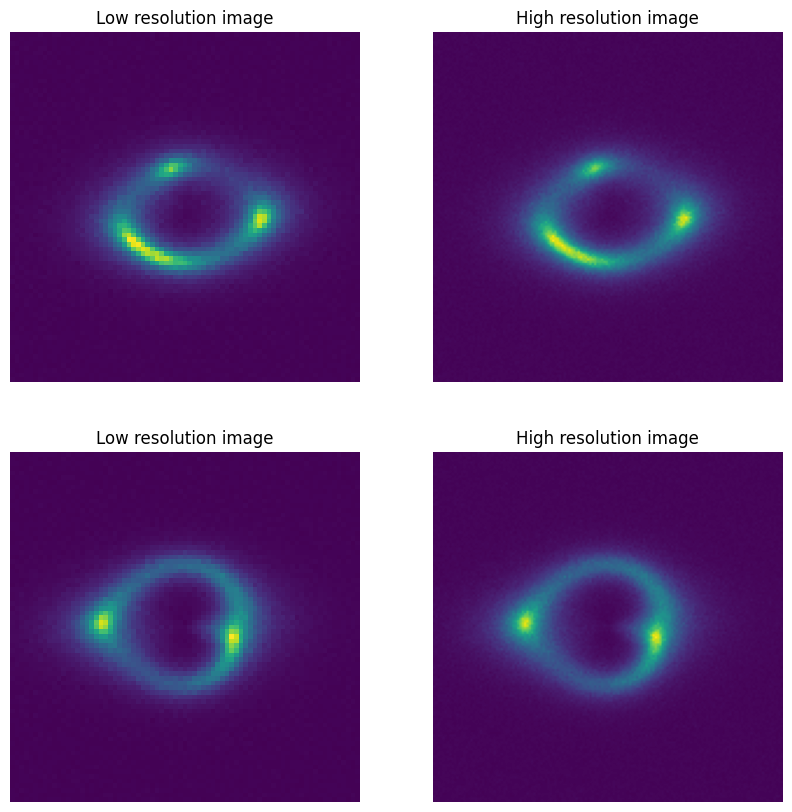

In [15]:
plt.figure(figsize = (10,10))
for i in range(2):
    plt.subplot(2,2,i*2+1)
    plt.imshow(np.load(LR_images[i])[0])
    plt.axis("off")
    plt.title("Low resolution image")
    plt.subplot(2,2,i*2+2)
    plt.imshow(np.load(HR_images[i])[0])
    plt.axis("off")
    plt.title("High resolution image")

In [16]:
train_HR_images, test_HR_images, train_LR_images, test_LR_images = train_test_split(HR_images, LR_images, test_size = 0.2)

# Model creation and training. Part 1, generator training

In [17]:
def conv3x3(in_channels, out_channels, stride=1, padding = "same"):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=padding, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

class DenseBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DenseBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride) 
        self.conv2 = conv3x3(in_channels, out_channels, stride)
        self.conv3 = conv3x3(in_channels, out_channels, stride)
        self.conv4 = conv3x3(in_channels, out_channels, stride)
        self.conv5 = conv3x3(in_channels, out_channels, stride)
    
    def forward(self, x):
        
        x1 = F.leaky_relu(self.conv1(x))+x
        x2 = F.leaky_relu(self.conv2(x1))+x+x1
        x3 = F.leaky_relu(self.conv3(x2))+x+x1+x2
        x4 = F.leaky_relu(self.conv4(x3))+x+x1+x2
        x4 = self.conv5(x4)
        return x4

In [18]:
class SuperResNet(pl.LightningModule):
    def __init__(self):
        """Initialise network"""
        super(SuperResNet, self).__init__()
        
        self.criterion = nn.MSELoss()
        self.conv1 = nn.Conv2d(
            in_channels = 1, 
            out_channels = 64, 
            kernel_size = 9, 
            stride=1, 
            padding="same"
        )
        self.prelu1 = nn.PReLU()
        residual_blocks = []
        for _ in range(16):
            residual_blocks.append(ResidualBlock(64, 64))
        
        self.residual_block = nn.Sequential(*residual_blocks)
        
        self.conv2 = nn.Conv2d(
            in_channels = 64, 
            out_channels = 64, 
            kernel_size = 3, 
            stride=1, 
            padding="same"
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(
            in_channels = 64, 
            out_channels = 64, 
            kernel_size = 3, 
            stride=1, 
            padding="same"
        )
        self.conv4 = nn.Conv2d(
            in_channels = 64, 
            out_channels = 256, 
            kernel_size = 3, 
            stride=1, 
            padding="same"
        )
        self.pixelshuffle1 = nn.PixelShuffle(upscale_factor=2)
        self.prelu2 = nn.PReLU()
        
        self.conv6 = nn.Conv2d(
            in_channels = 64, 
            out_channels = 1, 
            kernel_size = 9, 
            stride=1, 
            padding=4, 
        )
        
    def forward(self, X):
        
        X1 = self.prelu1(self.conv1(X))
        X = self.residual_block(X1)
        X = self.bn1(self.conv2(X))
        # X = self.conv2(X)
        X = X + X1
        X = self.prelu2(self.pixelshuffle1(self.conv4(X)))
        X = self.conv6(X)
        
        return X
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return [optimizer]
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        return pred, y
        

In [19]:
data_module = LensDataModule(train_HR_images, test_HR_images, train_LR_images, test_LR_images)
model = SuperResNet()

In [78]:
# Uncomment next line to load trained weights

model.load_state_dict(torch.load("superres.model"))

<All keys matched successfully>

In [22]:
trainer = pl.Trainer(max_epochs = 30, accelerator = "gpu", enable_progress_bar = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type         | Params
-------------------------------------------------
0  | criterion      | MSELoss      | 0     
1  | conv1          | Conv2d       | 5.2 K 
2  | prelu1         | PReLU        | 1     
3  | residual_block | Sequential   | 1.2 M 
4  | conv2          | Conv2d       | 36.9 K
5  | bn1            | BatchNorm2d  | 128   
6  | conv3          | Conv2d       | 36.9 K
7  | conv4          | Conv2d       | 147 K 
8  | pixelshuffle1  | PixelShuffle | 0     
9  | prelu2         | PReLU        | 1     
10 | conv6          | Conv2d       | 5.2 K 
-------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.664     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bot

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


# Generator-only training Test Metrics

In [23]:
preds = trainer.predict(model, data_module.test_dataloader())

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [25]:
pred = np.zeros((len(preds)*16, 150, 150))
true = np.zeros((len(preds)*16, 150, 150))
for i, value in enumerate(preds):
    pred[i*16:(i+1)*16] = value[0][:,0]
    true[i*16:(i+1)*16] = value[1][:,0]

In [26]:
print("Mean Squared Error:", np.mean((pred-true)**2))

Mean Squared Error: 6.024510088736257e-05


In [27]:
print("Structural Similarity:", ssim(true, pred))

Structural Similarity: 0.9951199233225698


In [28]:
print("PSNR:", psnr(true, pred))

PSNR: 42.20078264007742


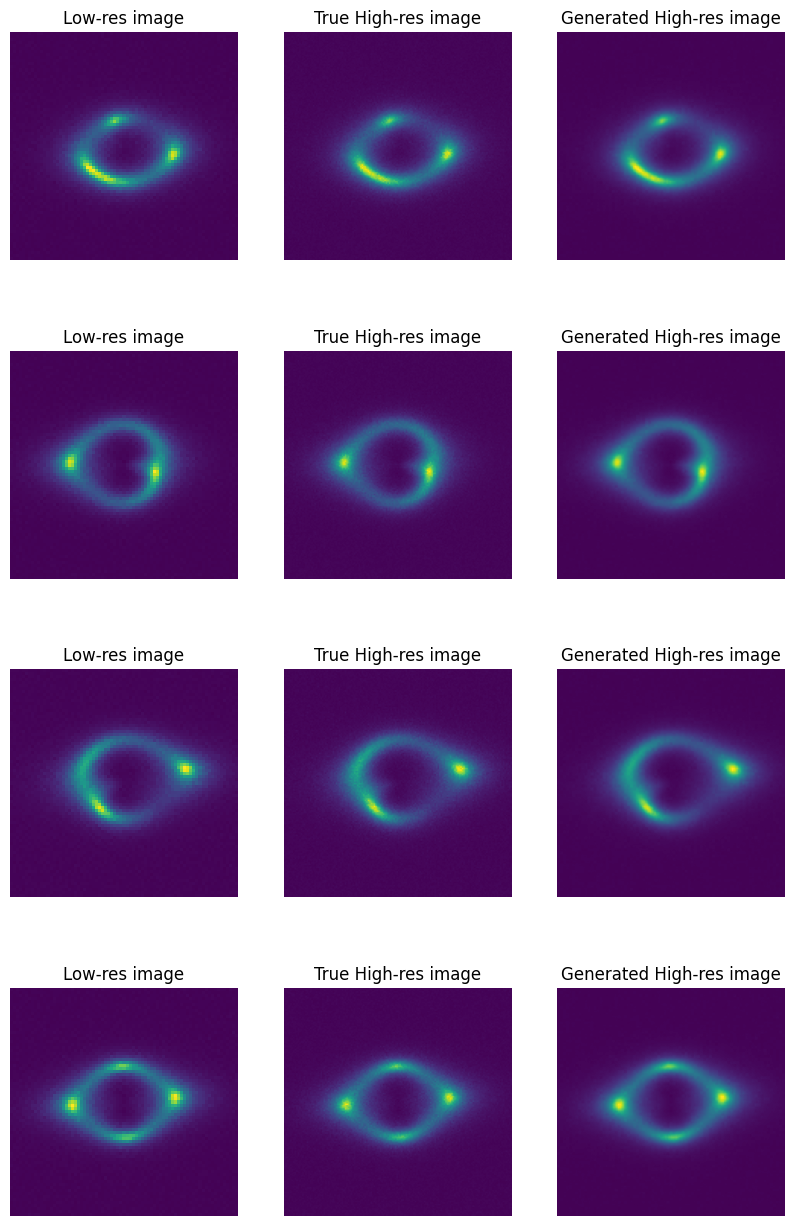

In [43]:
plt.figure(figsize = (10,20))
for i in range(4):
    
    lr_image = np.load(LR_images[i])
    hr_image = np.load(HR_images[i])
    with torch.no_grad():
        gen_image = model(torch.Tensor(lr_image).reshape(1,*lr_image.shape))
    plt.subplot(5,3,i*3+1)
    plt.imshow(lr_image[0])
    plt.axis("off")
    plt.title("Low-res image")
    plt.subplot(5,3,i*3+2)
    plt.imshow(hr_image[0])
    plt.axis("off")
    plt.title("True High-res image")
    plt.subplot(5,3,i*3+3)
    plt.imshow(gen_image[0][0])
    plt.axis("off")
    plt.title("Generated High-res image")

In [45]:
# Uncomment next line to save trained model. 

# torch.save(model.state_dict(), "superres.model")

# GAN training for better SSIM and PSNR

In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        """Initialise network"""
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, 
            out_channels = 64, 
            kernel_size = 3, 
            stride=1, 
            padding=1, 
        )
        self.conv2 = nn.Conv2d(
            in_channels = 64, 
            out_channels = 64, 
            kernel_size = 3, 
            stride=2, 
            padding=1, 
        )
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(
            in_channels = 64, 
            out_channels = 128, 
            kernel_size = 3, 
            stride=1, 
            padding=1, 
        )
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(
            in_channels = 128, 
            out_channels = 128, 
            kernel_size = 3, 
            stride=2, 
            padding=1, 
        )
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(
            in_channels = 128, 
            out_channels = 256, 
            kernel_size = 3, 
            stride=1, 
            padding=1, 
        )
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(
            in_channels = 256, 
            out_channels = 256, 
            kernel_size = 3, 
            stride=2, 
            padding=1, 
        )
        self.bn6 = nn.BatchNorm2d(256)
        
        self.conv7 = nn.Conv2d(
            in_channels = 256, 
            out_channels = 512, 
            kernel_size = 3, 
            stride=1, 
            padding=1, 
        )
        self.bn7 = nn.BatchNorm2d(512)
        
        self.conv8 = nn.Conv2d(
            in_channels = 512, 
            out_channels = 512, 
            kernel_size = 3, 
            stride=2, 
            padding=1, 
        )
        self.bn8 = nn.BatchNorm2d(512)
        self.flatten = nn.Flatten()
        self.linear1 = nn.LazyLinear(1024)
        self.linear2 = nn.Linear(1024, 1)
        
    def forward(self, X):
        
        X = F.leaky_relu(self.conv1(X), negative_slope=0.2)
        X = F.leaky_relu(self.bn2(self.conv2(X)), negative_slope=0.2)
        X = F.leaky_relu(self.bn3(self.conv3(X)), negative_slope=0.2)
        X = F.leaky_relu(self.bn4(self.conv4(X)), negative_slope=0.2)
        X = F.leaky_relu(self.bn5(self.conv5(X)), negative_slope=0.2)
        X = F.leaky_relu(self.bn6(self.conv6(X)), negative_slope=0.2)
        X = F.leaky_relu(self.bn7(self.conv7(X)), negative_slope=0.2)
        X = F.leaky_relu(self.bn8(self.conv8(X)), negative_slope=0.2)
        X = F.leaky_relu(self.linear1(self.flatten(X)), negative_slope=0.2)
        X = self.linear2(X)
        return X
        

In [64]:
class GANFramework(pl.LightningModule):
    def __init__(self, generator, discriminator):
        
        super(GANFramework, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
        self.generator_loss = nn.MSELoss()
        self.discriminator_loss = nn.BCEWithLogitsLoss()
    
    def forward(self, X):
        pass
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        # batch returns x and y tensors
        X, y = batch
        # ground truth (tensors of ones and zeros) same shape as images
        valid = torch.ones(X.size(0), 1).to(X.device).requires_grad_(True)
        fake = torch.zeros(X.size(0), 1).to(X.device).requires_grad_(True)
        
        # svaing loss_function as local variable
        
        # As there are 2 optimizers we have to train for both using 'optimizer_idx'
        ## Generator
        if optimizer_idx == 0:
            self.gen_images = self.generator(X)
            
            # Calculating generator loss
            # How well the generator can create real images
            g_loss = 0.1*self.discriminator_loss(self.discriminator(self.gen_images), valid) + 0.6*self.generator_loss(self.gen_images, y)
            # for output and logging purposes (return as dictionaries)
            self.log("g_loss", g_loss, prog_bar=True)
            return g_loss

        ## Discriminator
        if optimizer_idx == 1:
            # Calculating disciminator loss
            # How well discriminator identifies the real and fake images
            real_loss = self.generator_loss(self.discriminator(y), valid)
            fake_loss = self.generator_loss(self.discriminator(self.gen_images.detach()), fake)
            d_loss = (real_loss + fake_loss)/2.0
            self.log("d_loss", d_loss, prog_bar=True)
            # for output and logging purposes (return as dictionaries)
            return d_loss
    
    def configure_optimizers(self):
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.4, 0.999))
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.4, 0.999))
        
        # return the list of optimizers and second empty list is for schedulers (if any)
        return [optimizer_G, optimizer_D], []
        

In [65]:
gan_model = GANFramework(model, Discriminator())

In [66]:
# Uncomment next line to load saved model 

# gan_model.generator.load_state_dict(torch.load("superres_gan.model"))

In [67]:
trainer = pl.Trainer(max_epochs = 30, accelerator = "auto", enable_progress_bar = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [68]:
trainer.fit(gan_model, data_module)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type              | Params
---------------------------------------------------------
0 | generator          | SuperResNet       | 1.4 M 
1 | discriminator      | Discriminator     | 4.7 M 
2 | generator_loss     | MSELoss           | 0     
3 | discriminator_loss | BCEWithLogitsLoss | 0     
---------------------------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.419    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


# GAN training Test Metrics

In [69]:
preds = trainer.predict(gan_model.generator, data_module.test_dataloader())

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 500it [00:00, ?it/s]

In [70]:
pred = np.zeros((len(preds)*16, 150, 150))
true = np.zeros((len(preds)*16, 150, 150))

for i, value in enumerate(preds):
    pred[i*16:(i+1)*16] = value[0][:,0]
    true[i*16:(i+1)*16] = value[1][:,0]

In [71]:
print("Mean Squared Error:", np.mean((pred-true)**2))

Mean Squared Error: 0.0002123284113128523


In [72]:
print("Structural Similarity:", ssim(true, pred))

Structural Similarity: 0.9833045469081642


In [73]:
print("PSNR:", psnr(true, pred))

PSNR: 36.72991889720783


In [74]:
torch.save(gan_model.generator.state_dict(), "superres_gan.model")

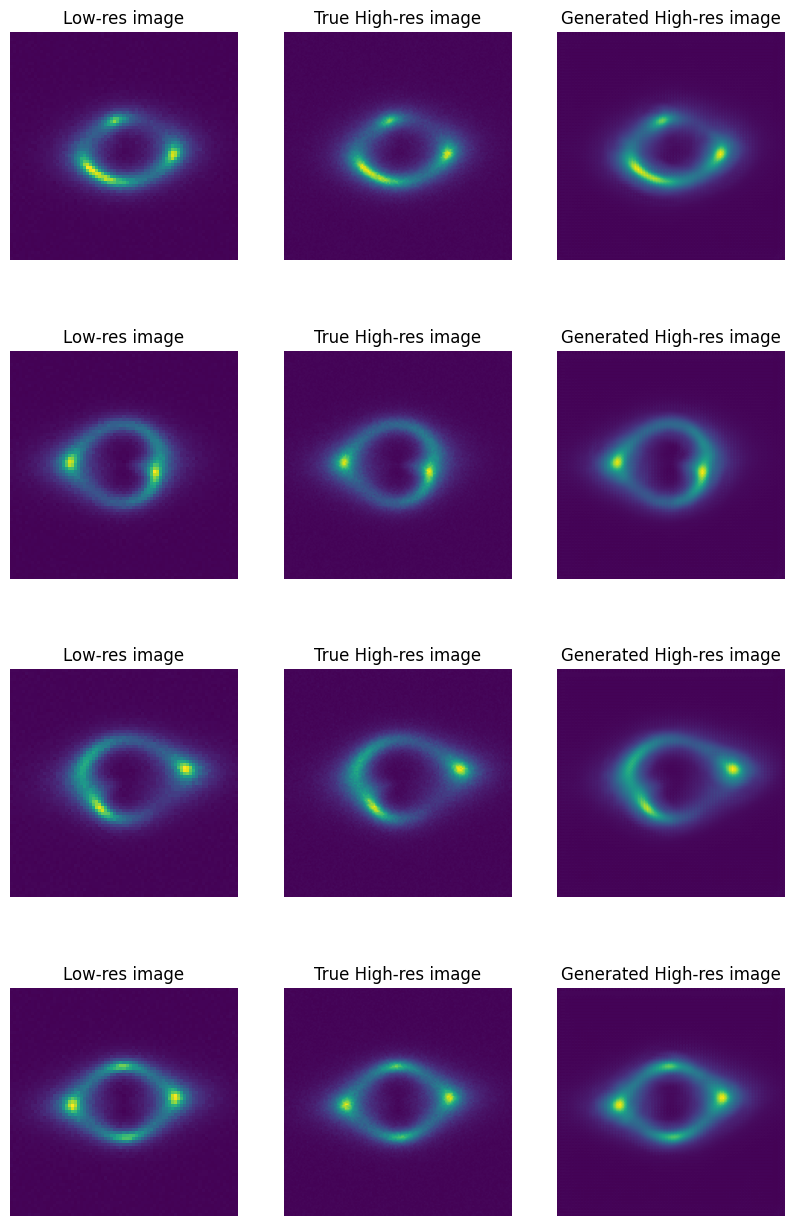

In [75]:
plt.figure(figsize = (10,20))
for i in range(4):
    
    lr_image = np.load(LR_images[i])
    hr_image = np.load(HR_images[i])
    with torch.no_grad():
        gen_image = gan_model.generator(torch.Tensor(lr_image).reshape(1,*lr_image.shape))
    plt.subplot(5,3,i*3+1)
    plt.imshow(lr_image[0])
    plt.axis("off")
    plt.title("Low-res image")
    plt.subplot(5,3,i*3+2)
    plt.imshow(hr_image[0])
    plt.axis("off")
    plt.title("True High-res image")
    plt.subplot(5,3,i*3+3)
    plt.imshow(gen_image[0][0])
    plt.axis("off")
    plt.title("Generated High-res image")